# meap analysis

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qgrid as qgrid
qgrid.nbinstall()

In [50]:
# consts for column names
score_code_col = 'DistrictCode'
staff_code_col = 'DCODE'
subject_col = 'Subject Name'
grade_col = 'Grade'
subgroup_col = 'Subgroup'
num_students_col = 'Number Tested'
proficient_col = 'Percent Proficient'
avg_score_col = 'Average Scaled Score'
stddev_col = 'Standard Deviation'
num_teachers_col = 'TEACHER'
num_librarians_col = 'LIB_SPEC'
num_library_support_col = 'LIB_SUPP'

In [51]:
# load stuff
scores = pd.read_csv('csv/12-13.csv')
staff = pd.read_csv('csv/librarians-per-district.csv')

# combine and drop unused
combined = pd.merge(scores, staff, left_on=score_code_col, right_on=staff_code_col)
combined = combined.drop('DCODE', 1).drop('DNAME', 1).drop('BuildingCode', 1)

In [52]:
# remove rows for which there are too few students to report scores
combined = combined[combined[num_students_col]!='< 10']

# removing '< 10' should only leave numbers in score columns
# we can convert these columns directly to floats to support numerical ops
combined = combined.convert_objects(convert_numeric=True)

# look at scores on district level only
combined = combined[combined['BuildingName']=='All Buildings']
combined = combined.drop('BuildingName', 1)

# replace NAN librarian cells with 0
fix_lib_idx = combined[num_librarians_col].isnull()
combined.loc[(fix_num_idx, num_librarians_col)] = 0
fix_lib_help_idx = combined[num_library_support_col].isnull()
combined.loc[(fix_lib_help_idx, num_library_support_col)] = 0

# print list of columns
combined.columns

Index(['SchoolYear', 'ISDCode', 'ISDName', 'DistrictCode', 'DistrictName',
       'Grade', 'Subject Name', 'Subgroup', 'Number Tested',
       'Level 1 Proficient', 'Level 2 Proficient', 'Level 3 Proficient',
       'Level 4 Proficient', 'Percent Proficient', 'Average Scaled Score',
       'Standard Deviation', 'TEACHER', 'INST_AID', 'INST_SUP', 'GUIDANCE',
       'LIB_SPEC', 'LIB_SUPP', 'LEA_ADM', 'LEA_SUPP', 'SCH_ADM', 'SCH_SUPP',
       'STU_SUPP', 'OTH_SUPP', 'SE_INSTR', 'SE_SUBJ', 'SE_CONS', 'SE_AID',
       'SE_SUPP', 'SE_OTH', 'CT_TEACH', 'CONS', 'LEA_DIR', 'COORD', 'SUPERVSR',
       'SCH_DIR'],
      dtype='object')

In [53]:
# compare scores only within a single grade + subject combination
grade_constraint = combined['Grade']==3
subject_constraint = combined['Subject Name']=='Reading'

# don't look at any particular subgroup yet
subgroup_constraint = combined['Subgroup']=='All Students'

data = combined[grade_constraint & subject_constraint & subgroup_constraint]
data = data.drop('Grade', 1).drop('Subject Name', 1).drop('Subgroup', 1)

In [54]:
desc_data = data[[num_students_col, proficient_col, avg_score_col, 
                  stddev_col, num_teachers_col, num_librarians_col, num_library_support_col]]
qgrid.show_grid(desc_data, remote_js=True)

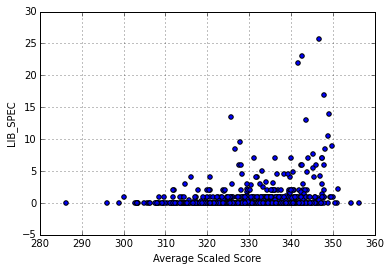

In [55]:
data.plot(x=avg_score_col, y=num_librarians_col, kind='scatter')